# Install dependencies

In [ ]:
!pip install pandas
!pip install datasets

# Import libraries & Setup the data directory

In [1]:
import os
import re
import glob
import shutil
import string
import pathlib


# set the data directory
data_dir = os.path.abspath(os.path.join(os.getcwd(),'..','data'))

# give matplotlib a folder to save its configs
os.environ['MPLCONFIGDIR'] = os.path.join(data_dir,'plt_configs')
import matplotlib.pyplot as plt

#give huggingface a folder to save its stuff in too
#you only need this if you are using a huggingface dataset
os.environ['HF_HOME'] = os.path.join(data_dir,'hf_cache')
import datasets

import PIL
import PIL.Image

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras.layers import TextVectorization

In [2]:
# setup directories, create them if they do not exist within data folder

# I want my data directory to contain two folders, one for each class I am predicting ("cats" or "dogs")

animals_dir = os.path.join(data_dir,'animals')
if not os.path.exists(animals_dir):
    os.makedirs(animals_dir)
    
cats_dir = os.path.join(data_dir,'animals','cats')
if not os.path.exists(cats_dir):
    os.makedirs(cats_dir)
    
dogs_dir = os.path.join(data_dir,'animals','dogs')
if not os.path.exists(dogs_dir):
    os.makedirs(dogs_dir)

# Download the dataset

* [cats_vs_dogs](https://huggingface.co/datasets/cats_vs_dogs)

In [3]:
# Load the dataset
dataset = datasets.load_dataset("cats_vs_dogs")

Found cached dataset cats_vs_dogs (/tf/data/hf_cache/datasets/cats_vs_dogs/default/1.0.0/d4fe9cf31b294ed8639aa58f7d8ee13fe189011837038ed9a774fde19a911fcb)


  0%|          | 0/1 [00:00<?, ?it/s]

# Explore the dataset

In [4]:
# Print first 5 records from dataset
animals_dataset = dataset['train'].to_pandas()
animals_dataset.head()

,image,labels
0,"{'bytes': None, 'path': '/tf/data/hf_cache/dat...",0
1,"{'bytes': None, 'path': '/tf/data/hf_cache/dat...",0
2,"{'bytes': None, 'path': '/tf/data/hf_cache/dat...",0
3,"{'bytes': None, 'path': '/tf/data/hf_cache/dat...",0
4,"{'bytes': None, 'path': '/tf/data/hf_cache/dat...",0


In [5]:
# length of animals dataset
len(animals_dataset)

23410

In [6]:
# divide the dataset into 2 dataframes
cats_df = animals_dataset[animals_dataset['labels'] == 0]
dogs_df = animals_dataset[animals_dataset['labels'] == 1]

# load the mugshat data from the '/data' folder
* [load and preprocess images](https://www.tensorflow.org/tutorials/load_data/images)

In [7]:
# print first 5 records of cats dataset
cats_df.head()

,image,labels
0,"{'bytes': None, 'path': '/tf/data/hf_cache/dat...",0
1,"{'bytes': None, 'path': '/tf/data/hf_cache/dat...",0
2,"{'bytes': None, 'path': '/tf/data/hf_cache/dat...",0
3,"{'bytes': None, 'path': '/tf/data/hf_cache/dat...",0
4,"{'bytes': None, 'path': '/tf/data/hf_cache/dat...",0


In [8]:
# print the path of first data of cats dataset
cats_df['image'][0]['path']

'/tf/data/hf_cache/datasets/downloads/extracted/c4333ea05164292151dda37c31bffe1889dba836e9f80c21a02e1063e61efbea/PetImages/Cat/0.jpg'

In [9]:
# save all cat images into cats directory
for i in range(len(cats_df)):
    shutil.copyfile(cats_df['image'][i]['path'], os.path.join(cats_dir,str(i)+'.jpg'))

In [10]:
# print the count of cat images available in the cat directory
image_count = len(list(pathlib.Path(cats_dir).glob('*.jpg')))
print(image_count)

11741


(500, 375)


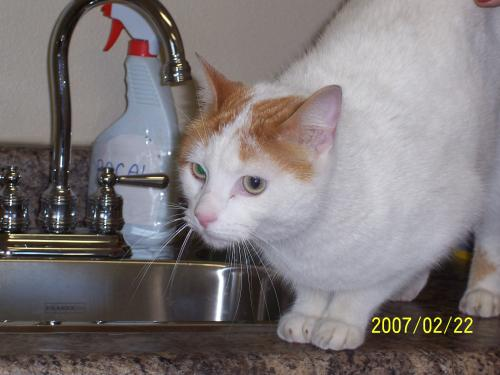

In [11]:
# print the first image from cats directory
cats = list(pathlib.Path(cats_dir).glob('*.jpg'))
print(PIL.Image.open(str(cats[0])).size)
PIL.Image.open(str(cats[0]))

(306, 500)


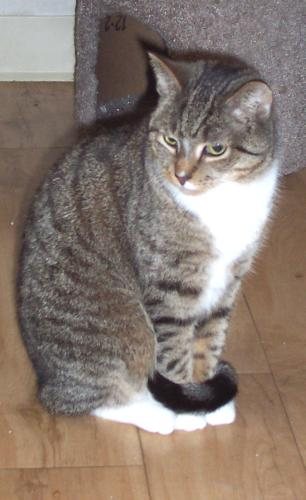

In [12]:
# print the second image from cats directory
print(PIL.Image.open(str(cats[1])).size)
PIL.Image.open(str(cats[1]))

(500, 408)


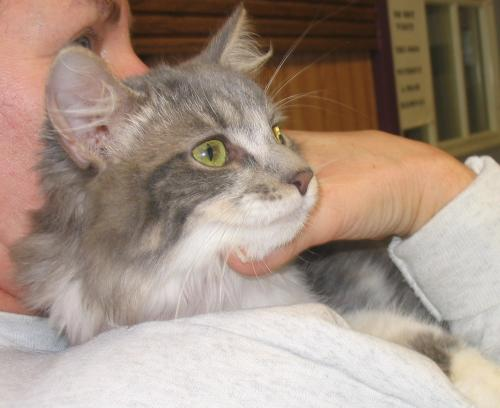

In [13]:
# print the last image from cats directory
print(PIL.Image.open(str(cats[-1])).size)
PIL.Image.open(str(cats[-1]))

In [14]:
# print first 5 records of dogs dataset
dogs_df.head()

,image,labels
11741,"{'bytes': None, 'path': '/tf/data/hf_cache/dat...",1
11742,"{'bytes': None, 'path': '/tf/data/hf_cache/dat...",1
11743,"{'bytes': None, 'path': '/tf/data/hf_cache/dat...",1
11744,"{'bytes': None, 'path': '/tf/data/hf_cache/dat...",1
11745,"{'bytes': None, 'path': '/tf/data/hf_cache/dat...",1


In [15]:
# print the path of first data of dogs dataset
dogs_df['image'][11741]['path']

'/tf/data/hf_cache/datasets/downloads/extracted/c4333ea05164292151dda37c31bffe1889dba836e9f80c21a02e1063e61efbea/PetImages/Dog/0.jpg'

In [16]:
# save all dog images into dogs directory
for i in range(len(cats_df),len(animals_dataset)):
    shutil.copyfile(dogs_df['image'][i]['path'], os.path.join(dogs_dir,str(i)+'.jpg'))

In [17]:
# print the count of dog images available in the dog directory
image_count = len(list(pathlib.Path(dogs_dir).glob('*.jpg')))
print(image_count)

11669


(500, 375)


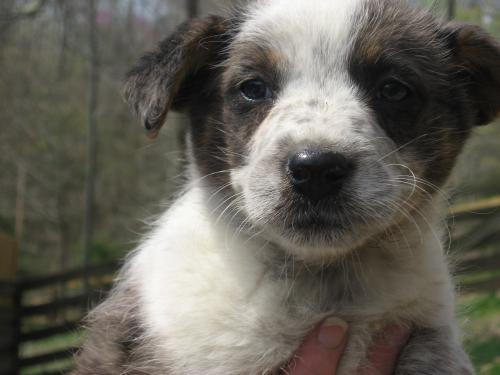

In [18]:
# print the first image from cats directory
dogs = list(pathlib.Path(dogs_dir).glob('*.jpg'))
print(PIL.Image.open(str(dogs[0])).size)
PIL.Image.open(str(dogs[0]))

(234, 273)


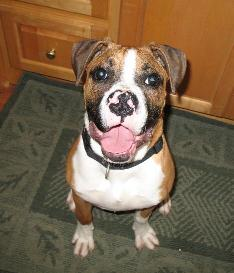

In [19]:
# print the second image from cats directory
print(PIL.Image.open(str(dogs[1])).size)
PIL.Image.open(str(dogs[1]))

(400, 434)


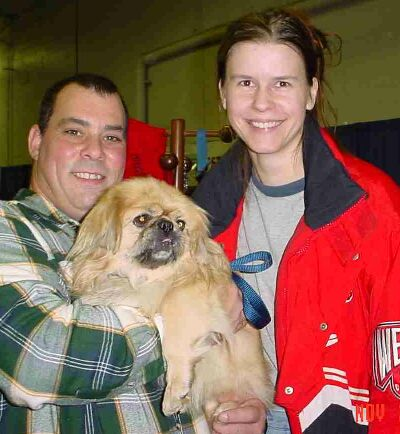

In [20]:
# print the second image from cats directory
print(PIL.Image.open(str(dogs[-1])).size)
PIL.Image.open(str(dogs[-1]))

# Setup Training Set

### Allocating 80% of the images for training and 20% for validation.

In [21]:
batch_size = 32 
img_height = 160
img_width = 160

train_ds = tf.keras.utils.image_dataset_from_directory(
  pathlib.Path(animals_dir),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  pathlib.Path(animals_dir),
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


### Printing class names in the class_names attribute on the datasets.

In [22]:
class_names = train_ds.class_names
print(class_names)

['cats', 'dogs']


# [Standardize and Fit](https://www.tensorflow.org/tutorials/load_data/images#standardize_the_data)

[https://www.tensorflow.org/tutorials/load_data/images#standardize_the_data](https://www.tensorflow.org/tutorials/load_data/images#standardize_the_data)

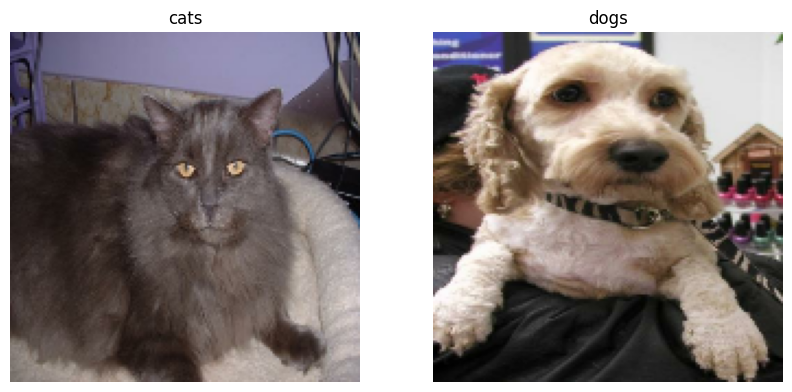

In [26]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(2):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

In [28]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [29]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [30]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
0.0 1.0


In [31]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [32]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [33]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
586/586 [==============================] - 166s 281ms/step - loss: 0.6290 - accuracy: 0.6566 - val_loss: 0.5475 - val_accuracy: 0.7187
Epoch 2/10
586/586 [==============================] - 169s 289ms/step - loss: 0.4810 - accuracy: 0.7693 - val_loss: 0.4606 - val_accuracy: 0.7789
Epoch 3/10
586/586 [==============================] - 158s 270ms/step - loss: 0.4052 - accuracy: 0.8120 - val_loss: 0.4148 - val_accuracy: 0.8103
Epoch 4/10
586/586 [==============================] - 151s 258ms/step - loss: 0.3486 - accuracy: 0.8429 - val_loss: 0.4484 - val_accuracy: 0.8082
Epoch 5/10
385/586 [==================>...........] - ETA: 52s - loss: 0.2734 - accuracy: 0.8819

KeyboardInterrupt: 

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(2):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
model = tf.keras.Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Save model and test prediction

In [ ]:
# TODO add code here